In [ ]:
import re

import requests
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
import contextily as ctx

from osmnx.geocoder import geocode

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Parameters

In [31]:
IDMC_API_KEY = "0UW3E9YFTD2W084U"
raw_data_dir = Path("../../data/raw")
processed_data_dir = Path("../../data/processed")
img_dir = Path("../../images")
# east_drc_coords = ((28.45, -3.745), (28.45, -1.4), (29.618, -1.4), (29.618, -3.745), (28.45, -3.745))
east_drc_coords = ((27.48, -4.5), (27.48, -1.4), (30.58, -1.4), (30.58, -4.5), (27.48, -4.5))
uvira_area_coords = ((29, -3.6), (29, -3.25), (29.28, -3.25), (29.28, -3.6), (29, -3.6))
# uvira_area_coords = ((29, -3.6), (29, -3.25), (29.23, -3.25), (29.23, -3.6), (29, -3.6))
# uvira_area_coords = ((29.1, -3.5), (29.1, -3.3), (29.23, -3.3), (29.23, -3.5), (29.1, -3.5))
uvira_point_coords = (29.143, -3.376)

## Functions

In [3]:
def create_list_of_locations(locations_string):
    remove_par = re.sub(r"\([^()]*\)", "", locations_string)
    remove_comment = re.sub(", creating a humanitarian disaster. Nord and Sud-Ubangi, Mongala and Kinshasa", "", remove_par)
    remove_num = re.sub(r"\d+", "", remove_comment)
    remove_and = re.sub(r"\band\b", ",", remove_num)
    remove_et = re.sub(r"\bet\b", ",", remove_and)
    remove_eq = re.sub(r"\bEquateur\b", "", remove_et)
    remove_nor = re.sub(r"\bNorthern area\b", "", remove_eq)
    remove_of = re.sub(r"\bof\b", ",", remove_nor)
    remove_empty = re.sub(r"\,\s+\,", "", remove_of)
    return (
        remove_empty
        .replace("Kimbaseke Ndjili", "Kimbaseke, Ndjili")
        .replace("Bukavu Burhinyi", "Bukavu, Burhinyi")
        .replace("Punia Kasongo", "Punia, Kasongo")
        .replace("Gaharawe", "Gatumba")
        .replace("Nyuempundu", "Nyamakarabo")
        .replace("Rukombe", "Nyamakarabo")
        .replace("Uwinterekwa", "Bujumbura Rural")
        .replace("Muhangadis", "Muhanga")
        .replace("Kanyenkoko", "Rumonge")
        .replace("Ngorero", "Ngororero")
        .replace("Mount Ngafula", "Mont Ngafula")
        .replace("Bujumbura Marie", "Bujumbura Mairie")
        .replace("Lisal", "Lisala")
        .replace("Dungu", "Ekibondo")
        .replace("area", "")
        .replace(".", ",")
        .replace(";", ",")
        .split(",")
    )


def remove_loc_types(location):
    loc_title = location.title()
    remove_district = re.sub(r"Distric\w+", "", loc_title)
    remove_province = re.sub(r"Provinc\w+", "", remove_district)
    remove_territory = re.sub(r"Territor\w+", "", remove_province)
    remove_city = re.sub(r"Cit\w+", "", remove_territory)
    remove_town = re.sub(r"Tow\w+", "", remove_city)
    remove_commune = re.sub(r"Commun\w+", "", remove_town)
    remove_municipality = re.sub(r"Municipalit\w+", "", remove_commune)
    return (
        remove_municipality
        .replace("Haut-Uele Sud-Kivu", "Haut-Uele")
        .strip()
    )

## Geo data

In [32]:
east_drc = gpd.GeoDataFrame(
    {"geometry": [Polygon(east_drc_coords)]},
    crs="EPSG:4326"
)
uvira_area = gpd.GeoDataFrame(
    {"geometry": [Polygon(uvira_area_coords)]},
    crs="EPSG:4326"
)
uvira_point = gpd.GeoDataFrame(
    {"geometry": [Point(uvira_point_coords)]},
    crs="EPSG:4326"
)

## IDP IDMC data

Data from: https://www.internal-displacement.org/database/displacement-data/ (https://www.internal-displacement.org/database/api-documentation/)


### Data Access URLs

**Annual Global Estimates (GIDD)**

Curated and validated in collaboration with external entities, these are IDMC’s most reliable internal displacement figures.
- Conflict Data:https://helix-tools-api.idmcdb.org/external-api/gidd/conflicts/?client_id={TOKEN}&format=json 
- Disaster Data: https://helix-tools-api.idmcdb.org/external-api/gidd/disasters/?client_id={TOKEN}&format=json 
- Combined Conflict & Disaster Data: https://helix-tools-api.idmcdb.org/external-api/gidd/displacements/?client_id={TOKEN}&format=json 
- Figure Analysis: https://helix-tools-api.idmcdb.org/external-api/gidd/public-figure-analyses/?client_id={TOKEN}&format=json 

**Internal Displacement Updates (IDU)**

Provides preliminary estimates of new displacement events. These figures are subject to updates and may not align with the Annual Global Estimates from GIDD, which undergo a more comprehensive quality control process.

- Last 180 Days:
https://helix-tools-api.idmcdb.org/external-api/idus/last-180-days/?client_id={TOKEN}&format=json 
- All IDUs:
https://helix-tools-api.idmcdb.org/external-api/idus/all/?client_id={TOKEN}&format=json 


### IDU

We focus on the displacement flow estimates because they are available for a longer period of time. More accurate numbers are available through the GIDD data for 2023.

In [5]:
idu_url = (
    # "https://helix-tools-api.idmcdb.org/external-api/gidd/disaggregations/disaggregation-geojson/?client_id="
    "https://helix-tools-api.idmcdb.org/external-api/idus/all/?client_id="
    + f"{IDMC_API_KEY}"
    + "&limit=600"
    + "&start_year=2016&end_year=2024"
    + "&iso3__in=COD"
    + "&format=json"
)

In [6]:
response = requests.get(idu_url)

In [7]:
idu_idmc_raw = (
    pd.DataFrame(response.json())
    .loc[lambda x: x["iso3"].isin(["COD", "BDI", "RWA"])]
    .assign(
        displacement_date = lambda x: pd.to_datetime(x["displacement_date"]),
        displacement_start_date = lambda x: pd.to_datetime(x["displacement_start_date"]),
        displacement_end_date = lambda x: pd.to_datetime(x["displacement_end_date"]),
        created_at = lambda x: pd.to_datetime(x["created_at"], format = "mixed").dt.normalize(),
    )
    .reset_index(drop=True)
)

In [8]:
idu_idmc_raw.isnull().sum()

id                            0
country                       0
iso3                          0
latitude                      1
longitude                     1
centroid                      0
role                          0
displacement_type             0
qualifier                     0
figure                        0
displacement_date             0
displacement_start_date       0
displacement_end_date         0
year                          0
event_id                      0
event_name                    0
event_codes                   0
event_code_types              0
event_start_date              0
event_end_date                0
category                   1471
subcategory                1471
type                       1471
subtype                    1471
standard_popup_text           0
standard_info_text            0
old_id                     1466
sources                       0
source_url                    0
locations_name                0
locations_coordinates         0
location

In [9]:
idp_idmc = (
    idu_idmc_raw
    [[
        "id",
        "country",
        "displacement_start_date",
        "displacement_end_date",
        "locations_coordinates",
        "locations_type",
        "role",
        "displacement_type",
        "qualifier",
        "figure",
        "created_at"
    ]]
    .assign(
        id_row = lambda x: x.reset_index().apply(lambda y: str(y["id"]) + "_" + str(y["index"]), axis = 1),
        locations_coordinates = lambda x: x["locations_coordinates"].str.replace(" ", "").str.split(";"),
        locations_type = lambda x: x["locations_type"].str.replace(" ", "").str.split(";"),
    )
    .explode(["locations_coordinates", "locations_type"])
    .loc[lambda x: ~(x["locations_type"].isin(["", "Originanddestination"]))]  # We assume that locations that are both origins and destination have zero flow
    .assign(
        geometry = lambda x: x["locations_coordinates"].apply(lambda y: Point(float(y.split(",")[1]), float(y.split(",")[0]))),
        figure = lambda x: x["figure"].where(
            x["locations_type"] == "Destination",
            -x["figure"]
        )
    )
    .assign(
        locations_number = lambda x: x.groupby(["id_row", "locations_type"])["locations_type"].transform("count"),
        figure = lambda x: x["figure"] / x["locations_number"]
    )
    .drop(columns = ["locations_coordinates", "locations_number"])
)

In [10]:
idp_idmc.head()

,id,country,displacement_start_date,displacement_end_date,locations_type,role,displacement_type,qualifier,figure,created_at,id_row,geometry
0,181774,Dem. Rep. Congo,2025-03-18,2025-03-24,Origin,Recommended figure,Conflict,more than or equal to,-124.0,2025-03-31 00:00:00+00:00,181774_0,POINT (30.58531 1.98918)
1,181807,Dem. Rep. Congo,2025-03-04,2025-03-04,Origin,Recommended figure,Conflict,more than or equal to,-10.0,2025-03-31 00:00:00+00:00,181807_1,POINT (28.367121 -2.05211)
2,181810,Dem. Rep. Congo,2025-03-01,2025-03-15,Origin,Recommended figure,Conflict,more than or equal to,-64000.0,2025-03-31 00:00:00+00:00,181810_2,POINT (28.88063 -4.26968)
4,180484,Dem. Rep. Congo,2025-02-26,2025-03-01,Origin,Triangulation,Conflict,total,-60.0,2025-03-06 00:00:00+00:00,180484_4,POINT (29.800381 2.10472)
4,180484,Dem. Rep. Congo,2025-02-26,2025-03-01,Destination,Triangulation,Conflict,total,60.0,2025-03-06 00:00:00+00:00,180484_4,POINT (30.48337 1.44187)


In [33]:
gdf_idp_uvira_idmc = (
    gpd.GeoDataFrame(
        data = idp_idmc,
        geometry = "geometry",
        crs = "EPSG:4326"
    )
    .loc[lambda x: x["geometry"].within(uvira_area.loc[0, "geometry"])]
    .reset_index(drop = True)
)

In [17]:
gdf_idp_uvira_idmc

,id,country,displacement_start_date,displacement_end_date,locations_type,role,displacement_type,qualifier,figure,created_at,id_row,geometry
0,181789,Dem. Rep. Congo,2025-02-01,2025-02-28,Origin,Recommended figure,Conflict,more than or equal to,-126000.0,2025-03-31 00:00:00+00:00,181789_19,POINT (29.1364 -3.40711)
1,170712,Dem. Rep. Congo,2024-11-01,2024-11-01,Origin,Triangulation,Disaster,more than or equal to,-124.0,2024-12-06 00:00:00+00:00,170712_192,POINT (29.2136 -3.34712)
2,39274,Dem. Rep. Congo,2022-02-02,2022-02-05,Destination,Triangulation,Conflict,total,6500.0,2022-06-14 00:00:00+00:00,39274_1477,POINT (29.2136 -3.34712)
3,39274,Dem. Rep. Congo,2022-02-02,2022-02-05,Destination,Triangulation,Conflict,total,6500.0,2022-06-14 00:00:00+00:00,39274_1477,POINT (29.1364 -3.40711)
4,39272,Dem. Rep. Congo,2022-02-02,2022-02-05,Destination,Triangulation,Conflict,total,6500.0,2022-06-14 00:00:00+00:00,39272_1478,POINT (29.2136 -3.34712)
5,39272,Dem. Rep. Congo,2022-02-02,2022-02-05,Destination,Triangulation,Conflict,total,6500.0,2022-06-14 00:00:00+00:00,39272_1478,POINT (29.1364 -3.40711)
6,38188,Dem. Rep. Congo,2022-01-31,2022-02-05,Destination,Recommended figure,Conflict,approximately,10500.0,2022-03-25 00:00:00+00:00,38188_1484,POINT (29.2136 -3.34712)
7,38188,Dem. Rep. Congo,2022-01-31,2022-02-05,Destination,Recommended figure,Conflict,approximately,10500.0,2022-03-25 00:00:00+00:00,38188_1484,POINT (29.1364 -3.40711)
8,38190,Dem. Rep. Congo,2022-01-30,2022-01-31,Origin,Recommended figure,Disaster,more than or equal to,-530.0,2022-03-25 00:00:00+00:00,38190_1486,POINT (29.2136 -3.34712)
9,39275,Dem. Rep. Congo,2022-01-27,2022-01-29,Destination,Recommended figure,Conflict,approximately,4000.0,2022-06-14 00:00:00+00:00,39275_1489,POINT (29.2136 -3.34712)


No Triangulation entries refer to the same location so we can aggregate values

In [18]:
(
    gdf_idp_uvira_idmc
    .loc[lambda x: x["role"] == "Triangulation"]
    .sort_values(["id", "created_at"], ascending = False)
)

,id,country,displacement_start_date,displacement_end_date,locations_type,role,displacement_type,qualifier,figure,created_at,id_row,geometry
1,170712,Dem. Rep. Congo,2024-11-01,2024-11-01,Origin,Triangulation,Disaster,more than or equal to,-124.0,2024-12-06 00:00:00+00:00,170712_192,POINT (29.2136 -3.34712)
11,57973,Dem. Rep. Congo,2021-09-15,2021-09-30,Origin,Triangulation,Conflict,more than or equal to,-2600.0,2021-11-01 00:00:00+00:00,57973_1624,POINT (29.2136 -3.34712)
14,45758,Dem. Rep. Congo,2018-10-14,2018-10-22,Origin,Triangulation,Conflict,more than or equal to,-3500.0,2018-11-12 00:00:00+00:00,45758_2286,POINT (29.1364 -3.40711)
15,40482,Dem. Rep. Congo,2018-07-24,2018-07-25,Origin,Triangulation,Conflict,less than or equal to,-255.0,2018-07-31 00:00:00+00:00,40482_2299,POINT (29.13406 -3.41078)
2,39274,Dem. Rep. Congo,2022-02-02,2022-02-05,Destination,Triangulation,Conflict,total,6500.0,2022-06-14 00:00:00+00:00,39274_1477,POINT (29.2136 -3.34712)
3,39274,Dem. Rep. Congo,2022-02-02,2022-02-05,Destination,Triangulation,Conflict,total,6500.0,2022-06-14 00:00:00+00:00,39274_1477,POINT (29.1364 -3.40711)
4,39272,Dem. Rep. Congo,2022-02-02,2022-02-05,Destination,Triangulation,Conflict,total,6500.0,2022-06-14 00:00:00+00:00,39272_1478,POINT (29.2136 -3.34712)
5,39272,Dem. Rep. Congo,2022-02-02,2022-02-05,Destination,Triangulation,Conflict,total,6500.0,2022-06-14 00:00:00+00:00,39272_1478,POINT (29.1364 -3.40711)


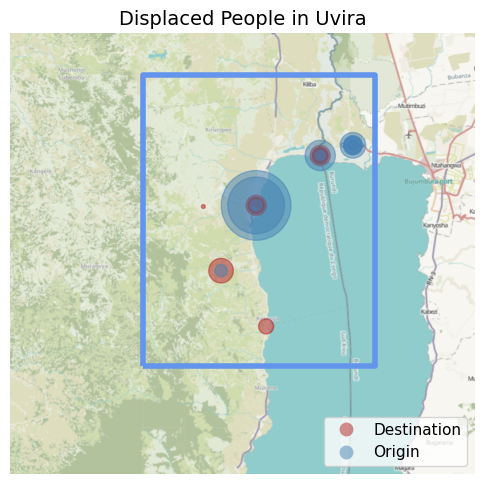

In [34]:
fig, ax = plt.subplots(figsize = (6, 6))
(
    gdf_idp_uvira_idmc
    .plot(
        ax = ax,
        column = "locations_type",
        cmap = ListedColormap(["firebrick", "steelblue"]),
        markersize = [(x / 50) if x > 0 else -(x/50) for x in gdf_idp_uvira_idmc["figure"]],
        alpha = 0.5,
        legend = True,
        legend_kwds = {
            "loc": "lower right",
            "fontsize": 11,
        }
    )
)
uvira_area.plot(
    ax = ax, 
    color = "none",
    edgecolor = "cornflowerblue",
    linewidth = 4
)
ax.set_axis_off()
ax.set_xlim(28.84, 29.4)
ax.set_ylim(-3.73, -3.2)
ax.set_title("Displaced People in Uvira", fontsize = 14)
ctx.add_basemap(
    ax,
    crs=gdf_idp_uvira_idmc.crs.to_string(),
    attribution = False
)
plt.savefig(img_dir / "idp_uvira_idmc_map.png", dpi = 300, bbox_inches = "tight")

### Expand events

In [35]:
gdf_idp_uvira_idmc.loc[lambda x: x["figure"] == x["figure"].min()]

,id,country,displacement_start_date,displacement_end_date,locations_type,role,displacement_type,qualifier,figure,created_at,id_row,geometry
0,181789,Dem. Rep. Congo,2025-02-01,2025-02-28,Origin,Recommended figure,Conflict,more than or equal to,-126000.0,2025-03-31 00:00:00+00:00,181789_19,POINT (29.1364 -3.40711)


In [36]:
df_idp_uvira_idmc = (
    gdf_idp_uvira_idmc
    .groupby(["id", "displacement_start_date", "displacement_end_date"])
    .agg(
        idps = ("figure", "sum")
    )
    .reset_index()
    .assign(
        date = lambda x: x.apply(lambda y: pd.date_range(y["displacement_start_date"], y["displacement_end_date"], freq = "D"), axis = 1)
    )
    .explode("date")
    .drop(columns = ["displacement_start_date", "displacement_end_date"])
    .assign(
        idps = lambda x: (x.groupby(["id"])["idps"].transform(lambda y: y / len(y))).astype(int)
    )
    .groupby(["date"])
    .agg(
        idps = ("idps", "sum")
    )
    .reset_index()
    [["date", "idps"]]
)


In [37]:
df_idp_uvira_idmc.shape

(261, 2)

### Create full dataframe

In [38]:
df_idp_dates_index = pd.date_range(
    start = df_idp_uvira_idmc["date"].min(),
    end = df_idp_uvira_idmc["date"].max(),
    freq = "D"
)
df_idp_dates = (
    pd.DataFrame(
        df_idp_dates_index,
        columns = ["date"]
    )
)
df_idp_uvira_idmc_full = (
    df_idp_dates
    .merge(
        df_idp_uvira_idmc,
        on = "date",
        how = "left"
    )
    .assign(
        idps = lambda x: x["idps"].fillna(0)
    )
    .groupby("date")
    .agg(
        idps = ("idps", "sum")
    )
    .reset_index()
)

<Axes: xlabel='date'>

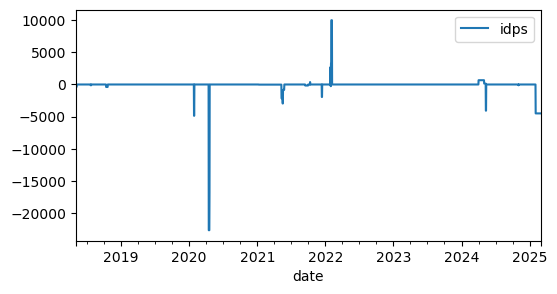

In [39]:
df_idp_uvira_idmc_full.set_index("date").plot(figsize = (6, 3))

## Conflicts

Data from: https://acleddata.com/data-export-tool/

- From: 2016-01-01
- To: 2025-02-20
- For: DRC, Burundi, Rwanda
- All events

In [40]:
df_acled = (
    pd.read_csv(
        raw_data_dir / "acled_2016-01-01-2025-02-20-Eastern_Africa-Middle_Africa-Burundi-Democratic_Republic_of_Congo-Rwanda.csv",
        parse_dates = ["event_date"]
    )
    [[
        "event_date",
        "country",
        "admin1",
        "admin2",
        "admin3",
        "location",
        "longitude",
        "latitude",
        "disorder_type",
        "fatalities",
        "population_best"
    ]]
)

In [41]:
df_acled.head()

,event_date,country,admin1,admin2,admin3,location,longitude,latitude,disorder_type,fatalities,population_best
0,2025-02-14,Democratic Republic of Congo,Nord-Kivu,Beni,Beni,Beni,29.4654,0.4966,Demonstrations,0,510735.0
1,2025-02-14,Democratic Republic of Congo,Sud-Kivu,Kabare,Kabare,Kavumu,28.7982,-2.2988,Political violence,0,5810.0
2,2025-02-14,Democratic Republic of Congo,Nord-Kivu,Lubero,Lubero,Baswagha,29.1581,0.0191,Strategic developments,0,NaN
3,2025-02-14,Democratic Republic of Congo,Sud-Kivu,Kabare,Kabare,Katana,28.8314,-2.2250,Political violence,0,11066.0
4,2025-02-14,Democratic Republic of Congo,Sud-Kivu,Bukavu,Ibanda,Bukavu,28.8667,-2.5000,Strategic developments,0,NaN


In [42]:
gdf_uvira_conflicts = (
    gpd.GeoDataFrame(
        df_acled,
        geometry = gpd.points_from_xy(df_acled["longitude"], df_acled["latitude"]),
        crs = "EPSG:4326"
    )
    # .loc[lambda x: x["geometry"].within(east_drc.loc[0, "geometry"])]    # if we want to consider larger area
    .loc[lambda x: x["geometry"].within(uvira_area.loc[0, "geometry"])]    # if we want to consider only area around Uvira
    .loc[lambda x: x["disorder_type"] != "Demonstrations"]
    # figure rescaling only necessary if we consider larger area
    # .to_crs("EPSG:3857")
    .assign(
        # distance = lambda x: x["geometry"].distance(uvira_point.to_crs("EPSG:3857").loc[0, "geometry"]) / 1000,
        # fatalities = lambda x: x["fatalities"] * np.exp(-x["distance"]/(20/0.693)),  # Fatalities half at 20 km
        # num_conflicts = lambda x: np.exp(-x["distance"]/(20/0.693))  # Conflict weight half at 20 km
        num_conflicts = 1
    )
    # .to_crs("EPSG:4326")
)

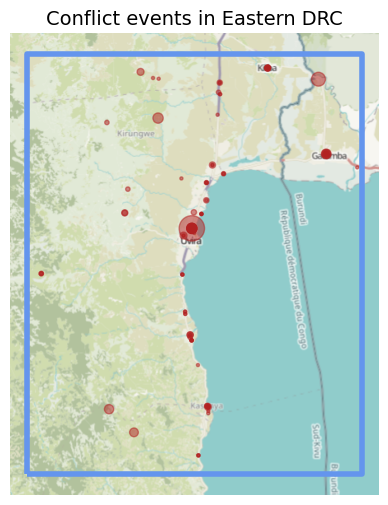

In [43]:
fig, ax = plt.subplots(figsize = (6, 6))
(
    gdf_uvira_conflicts
    .plot(
        ax = ax,
        color = "firebrick",
        alpha = 0.5,
        markersize = gdf_uvira_conflicts["fatalities"] * 5,
        # label = "Conflict events",
        # legend = True,
        # legend_kwds = {
        #     "loc": "upper right"
        # }
    )
)
(
    uvira_area
    .plot(
        ax = ax, 
        color = "none",
        edgecolor = "cornflowerblue",
        linewidth = 4
    )
)
# leg = ax.legend(markerscale = 1)
ax.set_axis_off()
# ax.set_xlim(25.5, 32)
# ax.set_ylim(-6, 0)
ax.set_title("Conflict events in Eastern DRC", fontsize = 14)
ctx.add_basemap(
    ax,
    crs=gdf_uvira_conflicts.crs.to_string(),
    attribution = False
)
plt.savefig(img_dir / "conflicts_east_drc_map.png", dpi = 300, bbox_inches = "tight")

In [44]:
df_uvira_daily_conflicts = (
    gdf_uvira_conflicts
    .groupby("event_date")
    .agg(
        num_conflicts = ("num_conflicts", "sum"),
        num_fatalities = ("fatalities", lambda x: int(sum(x.dropna())))
    )
    .reset_index()
    .rename(
        columns = {
            "event_date": "date"
        }
    )
)

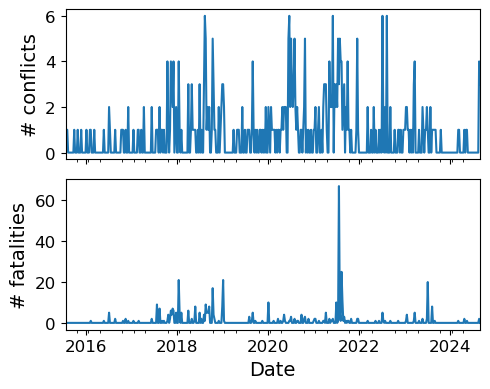

In [45]:
fig, axes = plt.subplots(2, 1, figsize = (5, 4), sharex=True)
(
    df_uvira_daily_conflicts
    .groupby(pd.Grouper(key = "date", freq = "7D"))
    .agg(
        num_conflicts = ("num_conflicts", "sum"),
    )
    .plot(
        ax = axes[0],
        legend = False
    )
)
# axes[0].set_yscale("log")
axes[0].set_ylabel("# conflicts", fontsize = 14)
axes[0].tick_params(labelsize = 12)
(
    df_uvira_daily_conflicts
    .groupby(pd.Grouper(key = "date", freq = "7D"))
    .agg(
        num_fatalities = ("num_fatalities", "sum"),
    )
    .plot(
        y = "num_fatalities",
        ax = axes[1],
        legend = False
    )
)
# axes[1].set_yscale("log")
axes[1].set_ylabel("# fatalities", fontsize = 14)
axes[1].tick_params(labelsize = 12)
axes[1].set_xlabel("Date", fontsize = 14)
axes[1].set(xticks=["2016-06-15", "2018-06-15", "2020-06-15", "2022-06-15", "2024-06-15"])
axes[1].set_xticklabels(["2016", "2018", "2020", "2022", "2024"])
plt.tight_layout()

In [46]:
df_acled_dates_index = pd.date_range(
    start = df_uvira_daily_conflicts["date"].min(),
    end = df_uvira_daily_conflicts["date"].max(),
    freq = "D"
)
df_acled_dates = (
    pd.DataFrame(
        df_acled_dates_index,
        columns = ["date"]
    )
)

df_uvira_daily_conflicts_full = (
    df_acled_dates
    .merge(
        df_uvira_daily_conflicts,
        on = "date",
        how = "left"
    )
    .assign(
        num_conflicts = lambda x: x["num_conflicts"].fillna(0),
        num_fatalities = lambda x: x["num_fatalities"].fillna(0)
    )
)

## Disaster data

Data from: https://public.emdat.be/

- For: DRC, Burundi, Rwanda
- Classification: Natural
- 2016-2025

The next few cells need to be run only the first time to geocode the raw dataset.

In [47]:
index_to_keep = [2, 3, 5, 7, 8, 11, 12, 14, 15, 16, 18, 19, 21, 22, 23, 25, 27, 28]  # Indices of cases close to Uvira
disasters_to_keep = ["Flood (General)", "Landslide (wet)", "Riverine flood", "Flash flood", "Severe weather"]
df_emdat_raw = (
    pd.read_csv(
        raw_data_dir / "emdat_drc_bdi_rwa_2025-02-27.csv",
    )
    [[
        "DisNo.",
        "Country",
        "ISO",
        "Location",
        "Origin",
        "Start Year",
        "Start Month",
        "Start Day",
        "End Year",
        "End Month",
        "End Day",
        "Disaster Group",
        "Disaster Subgroup",
        "Disaster Type",
        "Disaster Subtype",
        "No. Injured",
        "No. Affected",
        "No. Homeless",
        "Total Deaths",
        "Total Affected",
    ]]
)

In [48]:
df_emdat_geocoded = (
    df_emdat_raw
    .rename(
        columns = lambda x: x.lower().replace(".", "").replace(" ", "_")
    )
    .rename(
        columns = {"location": "disaster_location"}
    )
    .loc[lambda x: (
        ~x["disaster_subtype"].isin(["Lava flow", "Viral disease", "Bacterial disease"])  # for now we exclude these 
    )]
    .dropna(subset = ["disaster_location"])
    .assign(
        disaster_location_clean = lambda x: x.apply(lambda y: [remove_loc_types(l) for l in create_list_of_locations(y["disaster_location"])], axis = 1),
        disaster_affected = lambda x: x[["no_injured", "no_affected", "no_homeless", "total_deaths", "total_affected"]].ffill(axis = 1).iloc[:, -1],
    )
    .explode("disaster_location_clean")
    .assign(
        disaster_affected = lambda x: x.groupby(["disno"])["disaster_affected"].transform(lambda y: y / len(y)),
        disaster_address = lambda x: x["disaster_location_clean"] + ", " + x["country"],
        disaster_address_geocoded = lambda x: x.apply(lambda y: geocode(y["disaster_address"]), axis = 1),
        geometry = lambda x: x["disaster_address_geocoded"].apply(lambda y: Point(y[1], y[0]))
    )   
    .reset_index(drop = True)
)

In [49]:
gdf_uvira_disasters = (
    gpd.GeoDataFrame(
        df_emdat_geocoded,
        geometry = "geometry",
        crs = "EPSG:4326"
    )
    # .loc[lambda x: x["geometry"].within(east_drc.loc[0, "geometry"])]
    .loc[lambda x: x["geometry"].within(uvira_area.loc[0, "geometry"])]
    .reset_index(drop = True)
    # .to_crs("EPSG:3857")
    .assign(
        start_day = lambda x: x["start_day"].fillna(15).astype(int),
        start_month = lambda x: x["start_month"].astype(int),
        start_year = lambda x: x["start_year"].astype(int),
        end_day = lambda x: x["end_day"].fillna(16).astype(int),
        end_month = lambda x: x["start_month"].astype(int),
        end_year = lambda x: x["start_year"].astype(int),
        start_date = lambda x: pd.to_datetime(x[["start_year", "start_month", "start_day"]].astype(str).agg("-".join, axis = 1)),
        end_date = lambda x: pd.to_datetime(x[["end_year", "end_month", "end_day"]].astype(str).agg("-".join, axis = 1)),
        # distance = lambda x: x["geometry"].distance(uvira_point.to_crs("EPSG:3857").loc[0, "geometry"]) / 1000,
        # disaster_affected = lambda x: x["disaster_affected"] * np.exp(-x["distance"]/(20/0.693)),  # affected numbers half at 20 km
        # num_disasters = lambda x: np.exp(-x["distance"]/(20/0.693))  # Conflict weight half at 20 km
        num_disasters = 1
    )
    .to_crs("EPSG:4326")   
    [[
        "disno",
        "start_date",
        "end_date",
        "disaster_address",
        "disaster_subtype",
        "disaster_affected",
        "num_disasters",
        "geometry"
    ]]
)

In [50]:
gdf_uvira_disasters.to_file(processed_data_dir / "gdf_uvira_disasters.geojson", driver = "GeoJSON")

In [51]:
gdf_uvira_disasters = gpd.read_file(processed_data_dir / "gdf_uvira_disasters.geojson")

In [52]:
gdf_uvira_disasters["disaster_subtype"].value_counts()

disaster_subtype
Flood (General)    8
Name: count, dtype: int64

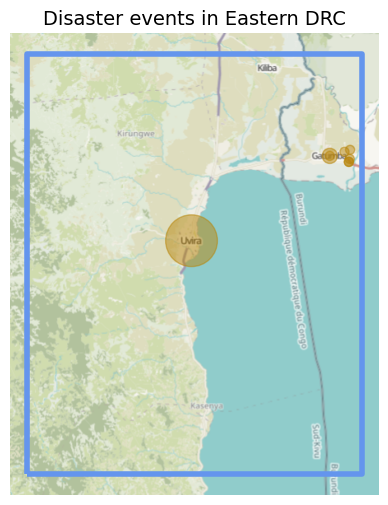

In [53]:
fig, ax = plt.subplots(figsize = (6, 6))
(
    gdf_uvira_disasters
    .plot(
        ax = ax,
        color = "darkgoldenrod",
        alpha = 0.5,
        markersize = gdf_uvira_disasters["disaster_affected"] * 0.03,
        # label = "Disaster events",
        # legend = True,
        # legend_kwds = {
            # "loc": "upper right"
        # }
    )
)
(
    uvira_area
    .plot(
        ax = ax, 
        color = "none",
        edgecolor = "cornflowerblue",
        linewidth = 4
    )
)
# leg = ax.legend(markerscale = 0.3)
ax.set_axis_off()
# ax.set_xlim(25.5, 32)
# ax.set_ylim(-6, 0)
ax.set_title("Disaster events in Eastern DRC", fontsize = 14)
ctx.add_basemap(
    ax,
    crs=gdf_uvira_disasters.crs.to_string(),
    attribution = False
)
plt.savefig(img_dir / "disasters_east_drc_map.png", dpi = 300, bbox_inches = "tight")

In [54]:
df_uvira_daily_disasters = (
    gdf_uvira_disasters
    .groupby(["disno", "start_date", "end_date"])
    .agg(
        num_disasters = ("num_disasters", lambda x: sum(x.dropna())),
        num_disaster_affected = ("disaster_affected", lambda x: sum(x.dropna()))
    )
    .reset_index()
    .assign(
        date = lambda x: x.apply(lambda y: pd.date_range(y["start_date"], y["end_date"], freq = "D"), axis = 1)
    )
    .explode("date")
    .assign(
        num_disasters = lambda x: x["num_disasters"].where(
            x["start_date"] == x["date"],
            0
        ),
        num_disaster_affected = lambda x: (x.groupby(["disno"])["num_disaster_affected"].transform(lambda y: y / len(y)))
    )
    .groupby("date")
    .agg(
        num_disasters = ("num_disasters", lambda x: sum(x.dropna())),
        num_disaster_affected = ("num_disaster_affected", lambda x: sum(x.dropna()))
    )
    .reset_index()
    [["date", "num_disasters", "num_disaster_affected"]]
)

In [55]:
df_uvira_daily_disasters.head()

,date,num_disasters,num_disaster_affected
0,2018-05-04,6,1439.555556
1,2018-05-05,0,1439.555556
2,2018-05-06,0,1439.555556
3,2018-05-07,0,1439.555556
4,2018-05-08,0,1439.555556


In [56]:
df_emdat_dates_index = pd.date_range(
    start = df_uvira_daily_disasters["date"].min(),
    end = df_uvira_daily_disasters["date"].max(),
    freq = "D"
)
df_emdat_dates = (
    pd.DataFrame(
        df_emdat_dates_index,
        columns = ["date"]
    )
)

df_uvira_daily_disasters_full = (
    df_emdat_dates
    .merge(
        df_uvira_daily_disasters,
        on = "date",
        how = "left"
    )
    .assign(
        num_disasters = lambda x: x["num_disasters"].fillna(0),
        num_disaster_affected = lambda x: x["num_disaster_affected"].fillna(0)
    )
)

In [57]:
df_uvira_daily_disasters_full.head()

,date,num_disasters,num_disaster_affected
0,2018-05-04,6.0,1439.555556
1,2018-05-05,0.0,1439.555556
2,2018-05-06,0.0,1439.555556
3,2018-05-07,0.0,1439.555556
4,2018-05-08,0.0,1439.555556


<Axes: xlabel='date'>

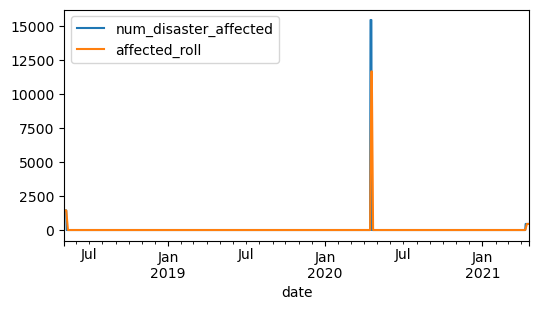

In [58]:
(
    df_uvira_daily_disasters_full
    .assign(
        affected_roll = lambda x: x["num_disaster_affected"].rolling(window = 4, win_type = "exponential", center=False, min_periods = 1).mean(tau=24),
        # affected_drop = lambda x:  ((x["num_disaster_affected"].shift(-1) == 0) & (x["num_disaster_affected"] > 0)).astype(int).cumsum().ewm(halflife = 7).mean(),
        # affected_drop_scaled = lambda x: x["affected_drop"]
    )
    # .loc[lambda x: x["date"] > "2020-04-01"]
    .set_index("date")
    [["num_disaster_affected", "affected_roll"]]
    .plot(figsize = (6, 3))
)

## Combine datasets

In [59]:
df_idp_conflict_disaster = (
    df_uvira_daily_conflicts_full
    .merge(
        df_uvira_daily_disasters_full,
        on = "date",
        how = "outer"
    )
    .merge(
        df_idp_uvira_idmc_full,
        on = "date",
        how = "outer"
    )
    .assign(
        num_conflicts = lambda x: x["num_conflicts"].fillna(0),
        num_fatalities = lambda x: x["num_fatalities"].fillna(0),
        num_disasters = lambda x: x["num_disasters"].fillna(0),
        num_disaster_affected = lambda x: x["num_disaster_affected"].fillna(0),
        # num_conflicts = lambda x: x["num_conflicts"].fillna(0).rolling(window = 90, win_type = "exponential", center=False, min_periods = 0).mean(tau=90),
        # num_fatalities = lambda x: x["num_fatalities"].fillna(0).rolling(window = 90, win_type = "exponential", center=False, min_periods = 0).mean(tau=90),
        # num_disasters = lambda x: x["num_disasters"].fillna(0).rolling(window = 90, win_type = "exponential", center=False, min_periods = 0).mean(tau=90),
        # num_disaster_affected = lambda x: x["num_disaster_affected"].fillna(0).rolling(window = 90, win_type = "exponential", center=False, min_periods = 0).mean(tau=90),
        # idps = lambda x: x["idps"].fillna(0).rolling(window = 90, win_type = "exponential", center=False, min_periods = 0).mean(tau=90)
    )
)

In [60]:
df_idp_conflict_disaster.head()

,date,num_conflicts,num_fatalities,num_disasters,num_disaster_affected,idps
0,2016-01-01,1.0,0.0,0.0,0.0,NaN
1,2016-01-02,0.0,0.0,0.0,0.0,NaN
2,2016-01-03,0.0,0.0,0.0,0.0,NaN
3,2016-01-04,0.0,0.0,0.0,0.0,NaN
4,2016-01-05,0.0,0.0,0.0,0.0,NaN


In [61]:
df_idp_conflict_disaster.isnull().mean()

date                     0.000000
num_conflicts            0.000000
num_fatalities           0.000000
num_disasters            0.000000
num_disaster_affected    0.000000
idps                     0.255154
dtype: float64

## Save

In [62]:
df_idp_conflict_disaster.to_csv(processed_data_dir / "idp_conflict_disaster.csv", index = False)

## Visualizations

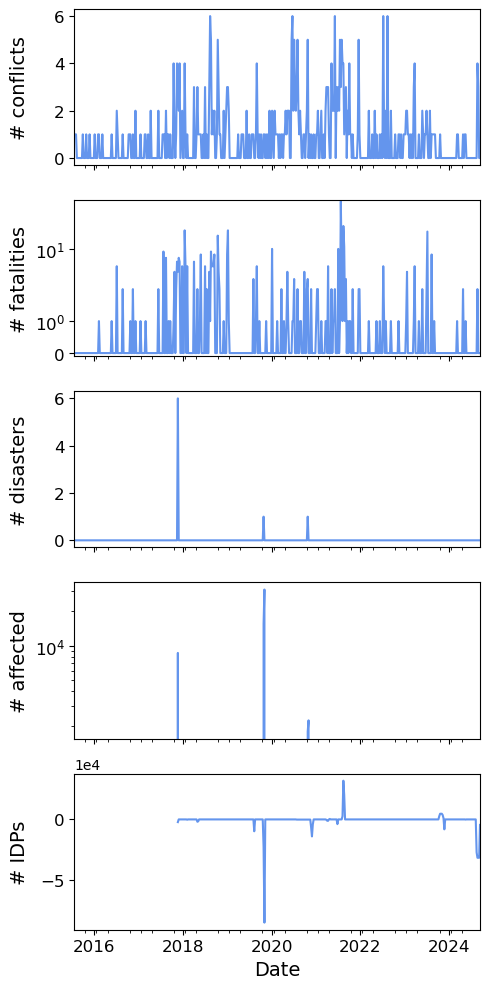

In [63]:
num_params = len(df_idp_conflict_disaster.columns[1:])
fig, axes = plt.subplots(num_params, 1, figsize = (5, num_params*2), sharex = True)
(
    df_idp_conflict_disaster
    .dropna(subset = ["num_fatalities"])
    .groupby(pd.Grouper(key = "date", freq = "7D"))
    .agg(
        num_conflicts = ("num_conflicts", "sum"),
    )
    .plot(
        ax = axes[0],
        color = "cornflowerblue",
        legend = False
    )
)
# axes[0].set_yscale("log")
axes[0].set_ylabel("# conflicts", fontsize = 14)
axes[0].tick_params(labelsize = 12)
(
    df_idp_conflict_disaster
    .dropna(subset = ["num_fatalities"])
    .groupby(pd.Grouper(key = "date", freq = "7D"))
    .agg(
        num_fatalities = ("num_fatalities", "sum"),
    )
    .plot(
        y = "num_fatalities",
        ax = axes[1],
        color = "cornflowerblue",
        legend = False
    )
)
axes[1].set_yscale("symlog")
axes[1].set_ylim(-0.1, None)
axes[1].set_ylabel("# fatalities", fontsize = 14)
axes[1].tick_params(labelsize = 12)
(
    df_idp_conflict_disaster
    .dropna(subset = ["num_disasters"])
    .groupby(pd.Grouper(key = "date", freq = "7D"))
    .agg(
        num_disasters = ("num_disasters", "sum"),
    )
    .plot(
        y = "num_disasters",
        ax = axes[2],
        color = "cornflowerblue",
        legend = False
    )
)
# axes[2].set_yscale("symlog")
# axes[2].set_ylim(-0.1, None)
axes[2].set_ylabel("# disasters", fontsize = 14)
axes[2].tick_params(labelsize = 12)
(
    df_idp_conflict_disaster
    .dropna(subset = ["num_disaster_affected"])
    .groupby(pd.Grouper(key = "date", freq = "7D"))
    .agg(
        num_disaster_affected = ("num_disaster_affected", "sum"),
    )
    .plot(
        y = "num_disaster_affected",
        ax = axes[3],
        color = "cornflowerblue",
        legend = False
    )
)
axes[3].set_yscale("log")
axes[3].set_ylabel("# affected", fontsize = 14)
axes[3].tick_params(labelsize = 12)
(
    df_idp_conflict_disaster
    .dropna(subset = ["idps"])
    .groupby(pd.Grouper(key = "date", freq = "7D"))
    .agg(
        idps = ("idps", "sum"),
    )
    .plot(
        y = "idps",
        ax = axes[4],
        color = "cornflowerblue",
        legend = False
    )
)
axes[4].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[4].set_ylabel("# IDPs", fontsize = 14)
axes[4].tick_params(labelsize = 12)
axes[4].set_xlabel("Date", fontsize = 14)
axes[4].set(xticks=["2016-06-15", "2018-06-15", "2020-06-15", "2022-06-15", "2024-06-15"])
axes[4].set_xticklabels(["2016", "2018", "2020", "2022", "2024"]);
axes[4].set_xlim(df_idp_conflict_disaster["date"].min(), df_idp_conflict_disaster["date"].max())
plt.tight_layout()
fig.align_ylabels()

In [103]:
df_idp_conflict_disaster.isnull().sum()

date                        0
num_conflicts               0
num_fatalities              0
num_disasters               0
num_disaster_affected       0
idps                     1040
dtype: int64